In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('whitegrid')

In [2]:
ad_data = pd.read_csv('advertising.csv')
ad_data.head(2)

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0


In [3]:
ad_data['Timestamp'] = pd.to_datetime(ad_data['Timestamp'])
date = pd.DatetimeIndex(ad_data['Timestamp'])
ad_data['year'] = date.year
ad_data['month'] = date.month
ad_data['day'] = date.strftime('%a')

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
train, test = train_test_split(ad_data, test_size=0.30, random_state=42)

In [6]:
train = train.sort_values('Timestamp')
train = train.drop(['Timestamp'], axis = 1)
                   
                   
test = test.sort_values('Timestamp')
test = test.drop(['Timestamp'], axis = 1)
test.head(2)

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Clicked on Ad,year,month,day
481,83.26,40,70225.60,187.76,Decentralized foreground infrastructure,Alanview,1,Tonga,0,2016,1,Sat
430,88.72,32,43870.51,211.87,Customer-focused system-worthy superstructure,East John,1,Zambia,0,2016,1,Sun


In [7]:
train.describe()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Clicked on Ad,year,month
count,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.0,700.000000
mean,65.063871,36.254286,54789.431614,181.162300,0.478571,0.494286,2016.0,3.805714
std,15.930506,8.934569,13501.401096,43.907143,0.499898,0.500325,0.0,1.922526
min,32.600000,19.000000,13996.500000,105.040000,0.000000,0.000000,2016.0,1.000000
25%,51.285000,29.000000,47029.292500,140.905000,0.000000,0.000000,2016.0,2.000000
50%,68.645000,35.000000,56941.905000,185.465000,0.000000,0.000000,2016.0,4.000000
75%,78.547500,42.000000,64665.640000,219.997500,1.000000,1.000000,2016.0,5.000000
max,91.430000,61.000000,79484.800000,261.520000,1.000000,1.000000,2016.0,7.000000


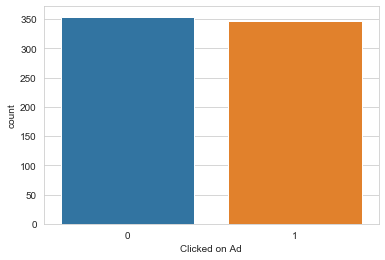

In [8]:
sns.countplot(train['Clicked on Ad'])

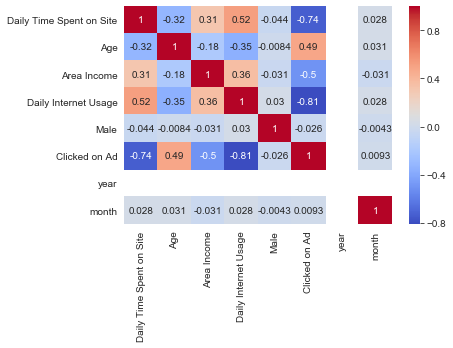

In [9]:
sns.heatmap(train.corr(), cmap = 'coolwarm', annot = True)

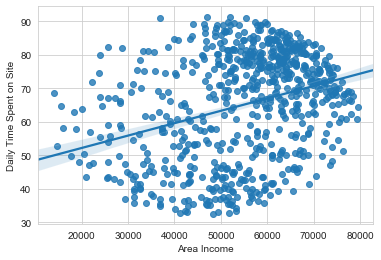

In [10]:
sns.regplot(x = train['Area Income'], y = train['Daily Time Spent on Site'])

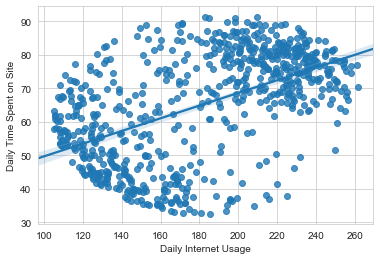

In [11]:
sns.regplot(x= train['Daily Internet Usage'], y = train['Daily Time Spent on Site'])

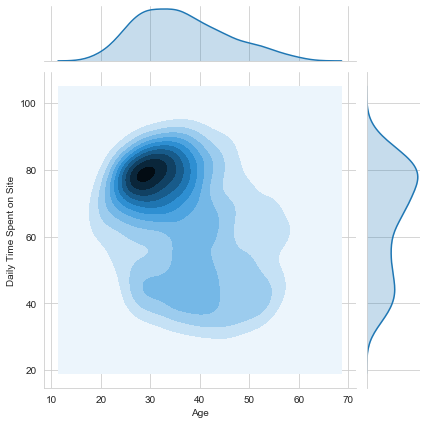

In [12]:
sns.jointplot(y = train['Daily Time Spent on Site'], x = train['Age'], kind = 'kde')

(array([  9.,  20.,  36.,  43.,  64., 117., 122., 152.,  90.,  47.]),
 array([13996.5 , 20545.33, 27094.16, 33642.99, 40191.82, 46740.65,
        53289.48, 59838.31, 66387.14, 72935.97, 79484.8 ]),
 <a list of 10 Patch objects>)

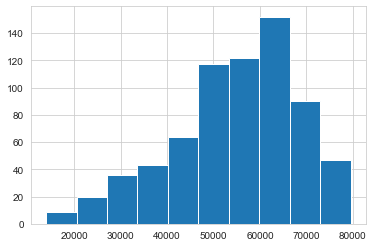

In [13]:
plt.hist(train['Area Income'])

In [14]:
# train['Area Income'].quantile(0.25) - 1.5* (train['Area Income'].quantile(0.75) -
#                                                       train['Area Income'].quantile(0.25)) #area income outlier

In [15]:
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
import string
from nltk.corpus import stopwords
from nltk.corpus import wordnet
stopwords = stopwords.words('english')
lema = WordNetLemmatizer()

def clean_a_text(text):                               #function for cleaning the text
    split_sentence = nltk.word_tokenize(text)
    no_punc = [char.lower() for char in split_sentence if char not in string.punctuation]
    sw_removed = [word for word in no_punc if word not in stopwords]
    lemmatized = [lema.lemmatize(word, pos = wordnet.VERB) for word in sw_removed]
    return lemmatized

In [16]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [17]:
vect = CountVectorizer(analyzer= clean_a_text)

In [18]:
vect.fit(train['Ad Topic Line'])

CountVectorizer(analyzer=<function clean_a_text at 0x000001A3FDAE8A60>,
                binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [19]:
train_words_count =  vect.transform(train['Ad Topic Line'])

test_words_count =  vect.transform(test['Ad Topic Line'])

In [20]:
features = vect.get_feature_names()

In [21]:
tfidf = TfidfTransformer()

In [22]:
tfidf.fit(train_words_count)
train_final_values = tfidf.transform(train_words_count)

test_final_values = tfidf.transform(test_words_count)

In [23]:
train_text_df = pd.DataFrame(data= train_final_values.toarray(), columns= features, index= train.index)

test_text_df = pd.DataFrame(data= test_final_values.toarray(), columns= features, index= test.index)

In [24]:
train_cat_df = train[['City', 'Country', 'day']]

test_cat_df = test[['City', 'Country', 'day']]

In [25]:
train_num_df = train.select_dtypes(include = 'number')
train_num_df = train_num_df.drop(['Clicked on Ad'], axis = 1)


test_num_df = test.select_dtypes(include = 'number')
test_num_df = test_num_df.drop(['Clicked on Ad'], axis = 1)

In [26]:
X_train = pd.concat([train_num_df, train_cat_df, train_text_df], axis = 1)

X_test = pd.concat([test_num_df, test_cat_df, test_text_df], axis = 1)

In [27]:
numerical_col = ['Daily Time Spent on Site', 'Age', 'Area Income',
                'Daily Internet Usage', 'Male', 'year', 'month']

In [28]:
categorical_col = train_cat_df.columns

In [29]:
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [30]:
numerical_transformer = Pipeline(steps = [('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps = [('onehot', OneHotEncoder(handle_unknown = 'ignore'))])

preprocessor = ColumnTransformer(transformers=[('num',numerical_transformer, numerical_col),
                                              ('cat', categorical_transformer, categorical_col)])

In [31]:
model = LogisticRegression()

my_pipeline = Pipeline(steps = [('preprocessor', preprocessor),
                               ('model', model)])

In [32]:
y_train = train['Clicked on Ad']
y_test = test['Clicked on Ad']

In [33]:
my_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['Daily Time Spent on Site',
                                                   'Age', 'Area Income',
                                     

In [34]:
pred = my_pipeline.predict(X_test)

In [35]:
from sklearn.metrics import classification_report, confusion_matrix

In [36]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       146
           1       0.98      0.94      0.96       154

    accuracy                           0.96       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.96      0.96      0.96       300



In [37]:
print(confusion_matrix(y_test, pred))

[[143   3]
 [  9 145]]
